In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import pandas as pd
import networkx as nx
import numpy as np
import sys
import seaborn as sns

In [22]:
results_folder = 'mmvec_major_taxa_2'
results_base_name = 'latent_dim_3_input_prior_1.00_output_prior_1.00_beta1_0.90_beta2_0.95'

# Input data

In [23]:
table = pd.read_table(results_folder + '/' + results_base_name + '_ranks.txt', index_col=0)
table.head()

,Propionibacteriaceae,Staphylococcus caprae or capitis,Staphylococcus epidermidis,Staphylococcus hominis,Other Staphylococci,Polyomavirus HPyV6,Polyomavirus HPyV7,Merkel Cell Polyomavirus,Malasseziaceae,Corynebacteriaceae,Micrococcaceae,Other families
featureid,,,,,,,,,,,,
X940001,0.111823,0.006616,0.050163,-0.001373,0.099477,0.048717,-0.015278,0.082663,-0.016479,0.391788,0.167430,0.036258
X940002,-0.037990,-0.158498,-0.256362,-0.062324,-0.022124,-0.070099,-0.090522,-0.089765,-0.051773,-0.057602,-0.087969,-0.121828
X940005,-0.035200,-0.181835,-0.301041,-0.328792,0.202456,0.600453,0.238876,0.140972,0.017801,0.009918,0.071340,-0.009364
X940007,0.445166,0.335722,0.224301,0.512379,0.381924,0.168751,0.260878,0.300112,0.413439,0.399129,0.329138,0.312755
X940010,0.302998,-0.218579,0.748987,0.499472,0.354388,0.560653,1.057405,0.859181,-0.107463,0.440688,0.758574,0.595320


Read microbiome metadata: Not needed as the taxon names are the column headers

Read metabolite metadata: Not needed as we are working with molecular families

# Check stats

There seams to be a local minimum of the model fit where all metabolites have (nearly) identical log conditional probabilities for every microbe.

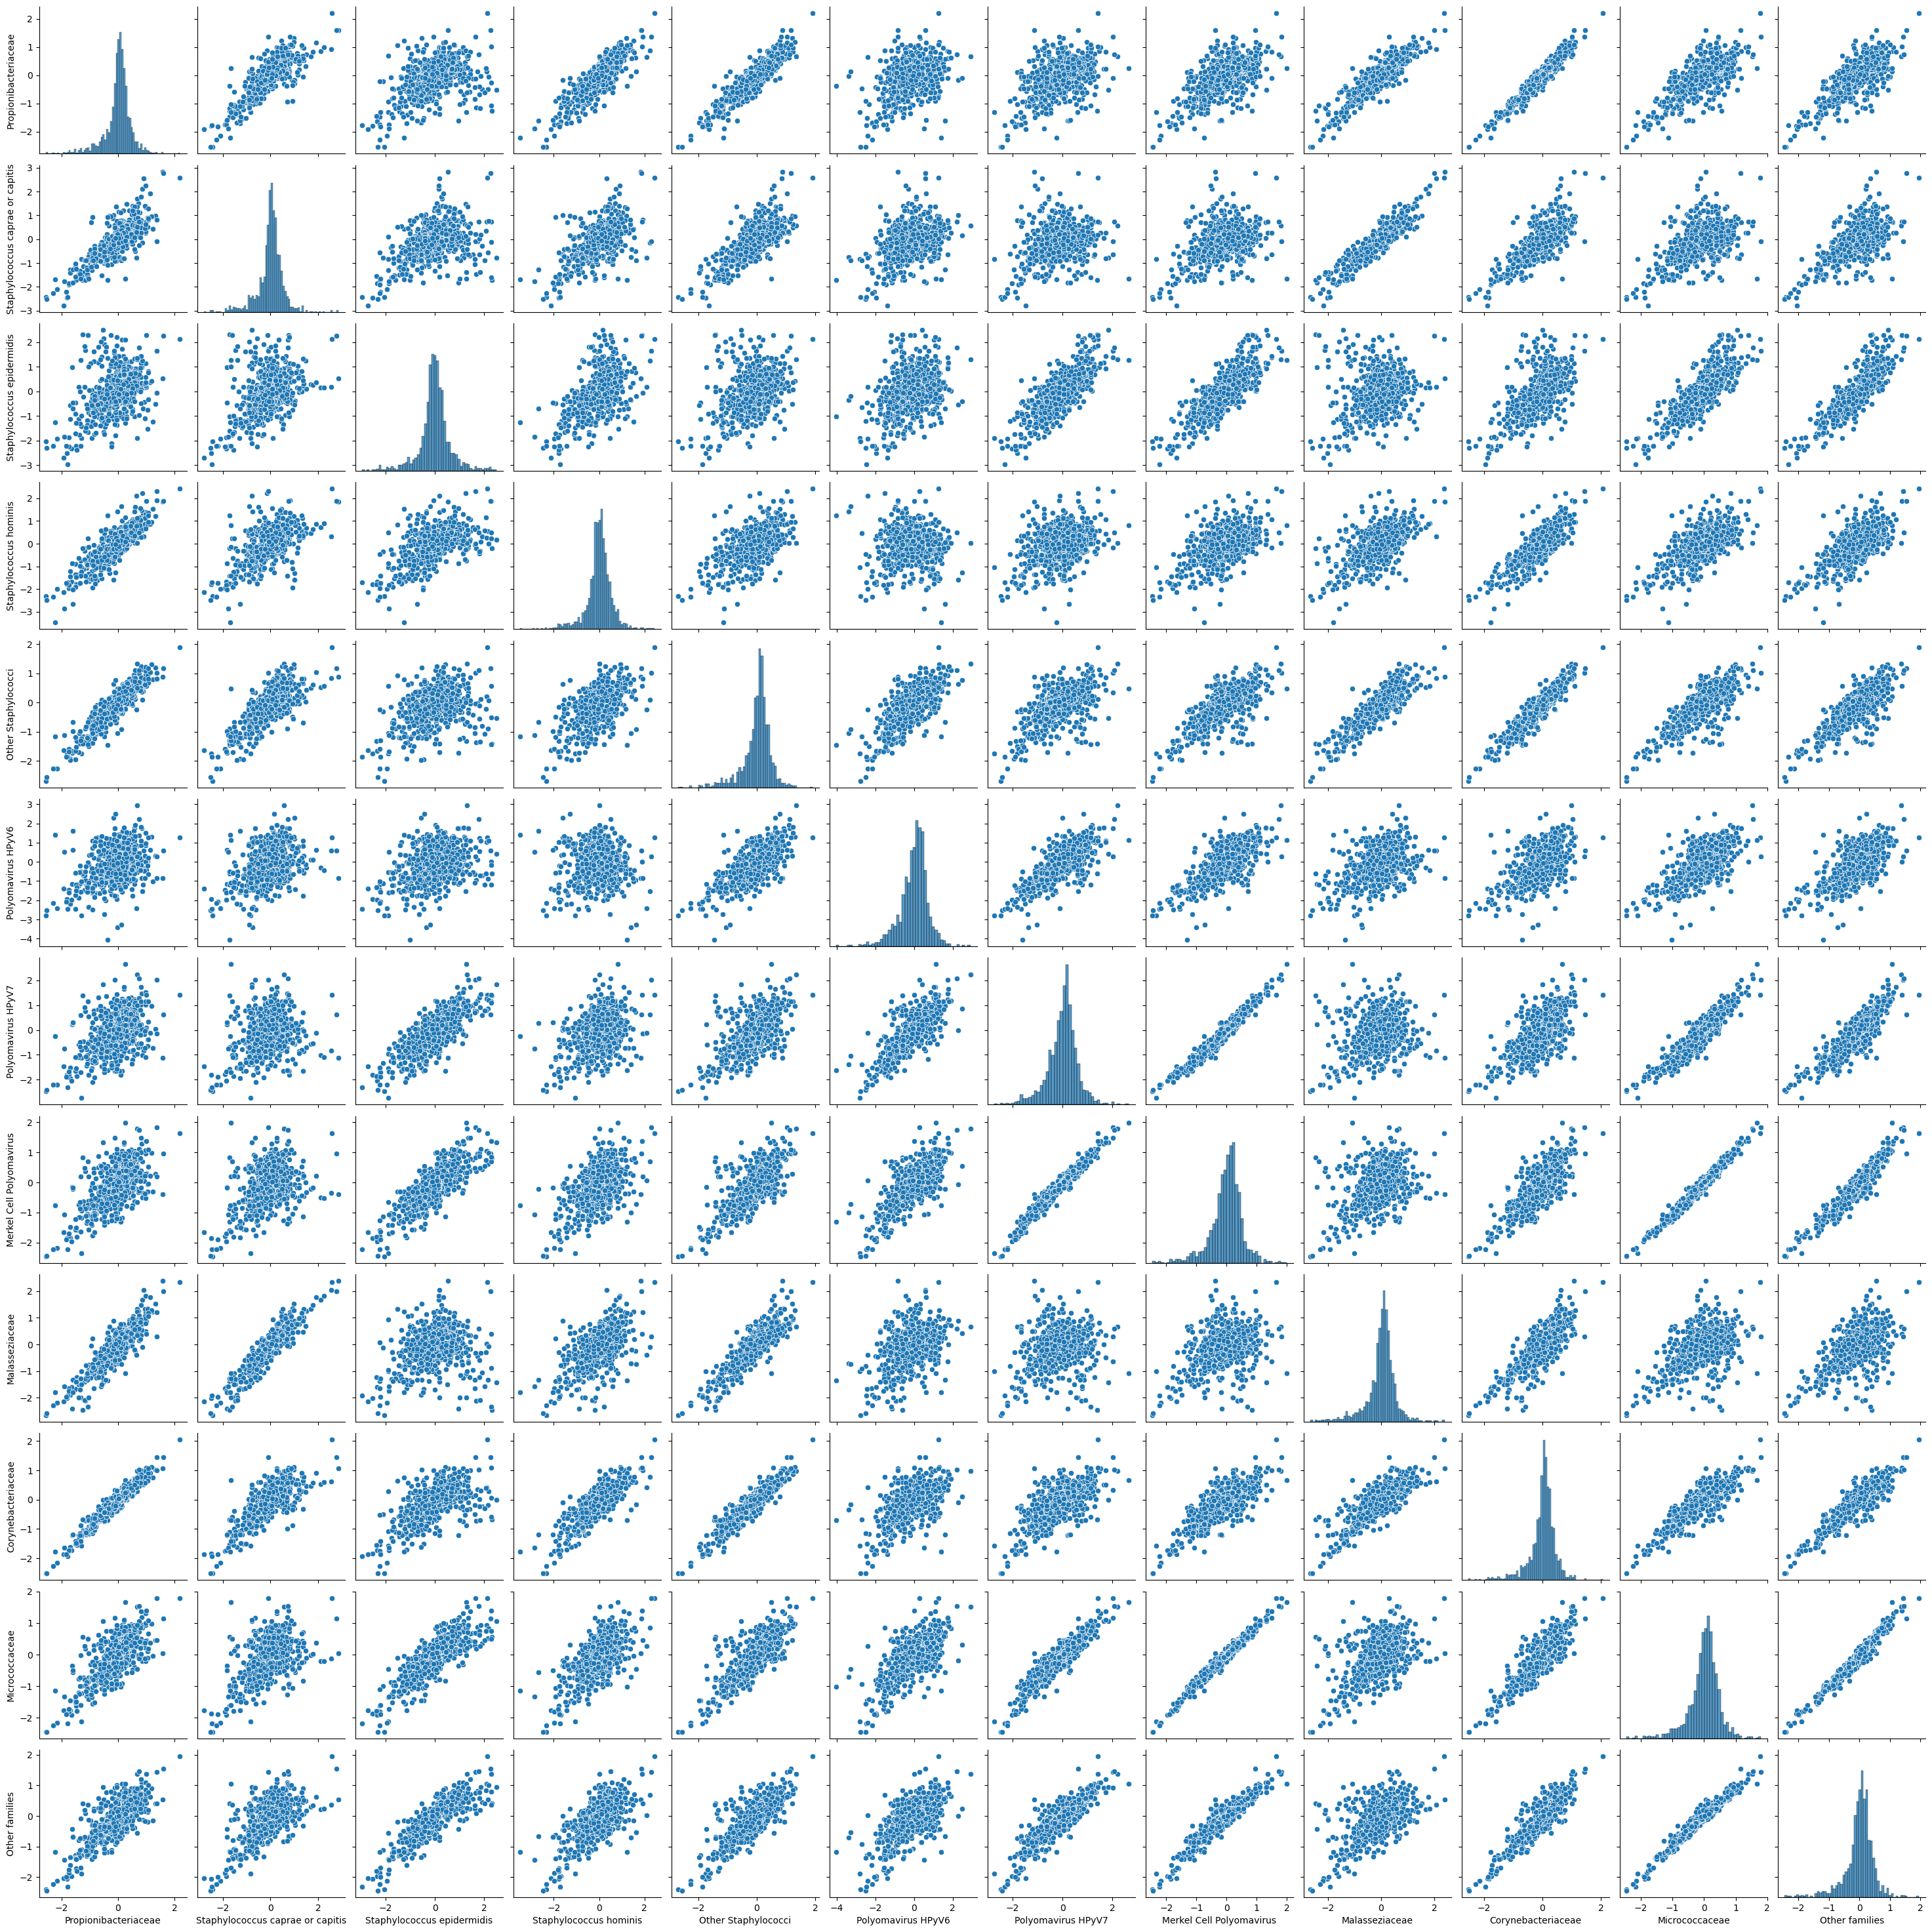

In [24]:
sns.pairplot(table)

The local density of this plot could be calculated with np.histogram:
https://stackoverflow.com/questions/33967513/creating-density-estimate-in-numpy
https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work

Because the data is m-dimensional (m = # microbes), we need np.histogramdd:
https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html

Alternatively, one could use an m-dimensional (m = # microbes) Hotelling ellipsoid at 95% cutoff:
https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

# Transform data

Transform into wide format and rank the results:

In [25]:
longform_pairwise = table.unstack().to_frame('interactionLogCondProb')
longform_pairwise['interactionLogCondProb_abs'] = abs(longform_pairwise['interactionLogCondProb'])
longform_pairwise['interactionLogCondProb_sign'] = np.where(longform_pairwise['interactionLogCondProb'] > 0, 
                                                                 'positive', 'negative')
longform_pairwise.sort_values('interactionLogCondProb_abs', ascending=False, inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.head()

,index,level_0,featureid,interactionLogCondProb,interactionLogCondProb_abs,interactionLogCondProb_sign
0,0,Polyomavirus HPyV6,X940239,-4.035139,4.035139,negative
1,1,Staphylococcus hominis,X970706,-3.476374,3.476374,negative
2,2,Polyomavirus HPyV6,X940091,-3.399606,3.399606,negative
3,3,Polyomavirus HPyV6,X960720,-3.279401,3.279401,negative
4,4,Staphylococcus epidermidis,X960386,-2.958227,2.958227,negative


# Graph

In [26]:
G = nx.Graph()
G = nx.from_pandas_edgelist(longform_pairwise, 'level_0', 'featureid',
                            edge_attr=['index', 'interactionLogCondProb', 'interactionLogCondProb_abs', 'interactionLogCondProb_sign'])
nx.info(G)

/tmp/ipykernel_1870/2291082867.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 1237 nodes and 14700 edges'

Add node_type as node attribute

In [27]:
microbe_metadata = pd.DataFrame(index = table.columns.values)
microbe_metadata['node_type'] = 'microbe' 
microbe_metadata.head()

,node_type
Propionibacteriaceae,microbe
Staphylococcus caprae or capitis,microbe
Staphylococcus epidermidis,microbe
Staphylococcus hominis,microbe
Other Staphylococci,microbe


In [28]:
metabolite_metadata = pd.DataFrame(index = table.index.values)
metabolite_metadata['node_type'] = 'metabolite' 
metabolite_metadata.head()

,node_type
X940001,metabolite
X940002,metabolite
X940005,metabolite
X940007,metabolite
X940010,metabolite


In [29]:
nx.set_node_attributes(G, microbe_metadata.T.to_dict())
nx.set_node_attributes(G, metabolite_metadata.T.to_dict())

In [30]:
nx.write_graphml(G, results_folder + '/' + results_base_name + '_graph.graphml')